When data is normal we use - Parametric Test which is done on mean as it is the central point.

When data is not normal (skewed) we use - Non-Parametric Test which is done on Median as it is the central point

# Problem Statement

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

In [1]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
from statsmodels.tools import add_constant as ac
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report,  mean_squared_error, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, Binarizer
sc = StandardScaler()
le = LabelEncoder()

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from collections import Counter
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
rfr = RandomForestRegressor()
rfc = RandomForestClassifier()
import warnings
warnings.filterwarnings('ignore')
global str

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [3]:
for i in train.columns:
    if i not in test.columns:
        target_var = i 

In [4]:
target_var

'Survived'

In [5]:
# General Grid Search Model that could be used by all Classification Models. 

def grid_search(model, params, df, encod = 'label', subm = 'no'):
    x_train, x_test, y_train, y_test = split_data(df)
    if encod == 'label':
        x_train = x_train.apply(LabelEncoder().fit_transform)
        x_test = x_test.apply(LabelEncoder().transform)
    else:
        x_train = pd.get_dummies(x_train)
        x_test = pd.get_dummies(x_test)
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)
    grid_mod = GridSearchCV(model, param_grid=params, cv = 10, n_jobs=-1, refit=True)
    grid_mod.fit(x_train, y_train)

    best_estimator = grid_mod.best_estimator_

    y_pred = grid_mod.predict(x_test)

    if subm == 'yes':
        sub(str(model)[:4], y_pred)

In [6]:
# Splitting combined into x_train, x_test, y_train, y_test

def split_data(df, y = target_var):

    x_train = df[df[y].notnull()]
    x_train.drop(y, inplace=True, axis=1)
    # x_train.head()

    x_test = df[df[y].isnull()]
    x_test.drop('Survived', inplace=True, axis=1)
    # x_test.head()

    y_train = df[df[y].notnull()]['Survived']
    # y_train.notnull().sum()
    # y_train = y_train.astype('int')

    y_test = df[df[y].isna()]['Survived']
    # y_test.isnull().sum()

    return x_train, x_test, y_train, y_test

In [7]:
def ret_latest_file(x):
    ans = os.listdir()
    finlist = []
    re_pat = re.compile("([a-zA-Z]+)([0-9]+)")
    for i in ans:
        try:            
            if i[-3:] == 'csv':
                res = re_pat.match(i).groups()                
                if res[0] == x:
                    finlist.append(int(res[1]) + 1)            
        except:
            pass
    if len(finlist) > 0:
        return res[0], max(finlist)
        # print(res[0], max(finlist))
    else:
        return x, 1
        # print(x, 1)

In [8]:
train[target_var] = train[target_var].astype('category')

# Converting target into Categorical

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    category
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    object  
 4   Sex          891 non-null    object  
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    object  
 11  Embarked     889 non-null    object  
dtypes: category(1), float64(2), int64(4), object(5)
memory usage: 77.7+ KB


In [10]:
combined = pd.concat([train, test], sort = False, ignore_index=True)

In [11]:
combined.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [12]:
# Preparing Data for submission

def sub(n, pred):
    name, num = ret_latest_file(n)
    sol = pd.read_csv('gender_submission.csv')
    # sol = pd.DataFrame({"PassengerId": test.PassengerId, "Survived": pred})
    sol.loc[:, target_var] = pred
    sol.to_csv(name + '{}.csv'.format(num), index=False)


In [13]:
# Base Submission

# sub('base', 0)

In [14]:
to_be_obj = ['Pclass', 'SibSp', 'Parch']
combined[to_be_obj] = combined[to_be_obj].astype(str)

<AxesSubplot:>

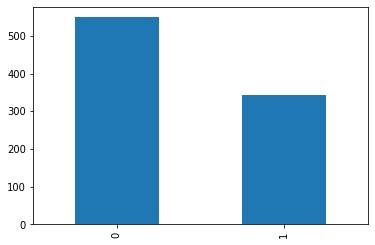

In [15]:
combined.Survived.value_counts().plot(kind = 'bar')

# There is a little imbalance in the data.
# We could try SMOTE (OverSampling) or Near Miss (UnderSampling) at a later stage.

In [16]:
for i in combined.select_dtypes('object'):
    combined[i] = combined[i].astype('category')

In [17]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  1309 non-null   int64   
 1   Survived     891 non-null    category
 2   Pclass       1309 non-null   category
 3   Name         1309 non-null   category
 4   Sex          1309 non-null   category
 5   Age          1046 non-null   float64 
 6   SibSp        1309 non-null   category
 7   Parch        1309 non-null   category
 8   Ticket       1309 non-null   category
 9   Fare         1308 non-null   float64 
 10  Cabin        295 non-null    category
 11  Embarked     1307 non-null   category
dtypes: category(9), float64(2), int64(1)
memory usage: 134.9 KB


In [18]:
combined.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

### EDA: Univariate Analysis

In [19]:
not_plot = ['PassengerId', 'Name', 'Ticket', 'Cabin']
color = ['red','blue','green']

In [20]:
def univariate(df = combined, rows = 3, cols = 4):
    fig=plt.figure(figsize=(20,20))
    for j, i in enumerate(df.columns):
        if i not in not_plot:
            ax=fig.add_subplot(rows,cols,j+1)
            if i in df.select_dtypes(['category', 'object']):
                sns.countplot(x= i, data = df, ax=ax)
            if i in df.select_dtypes(['int', 'float64']):
                sns.distplot(x = df[i], ax=ax, color=np.random.choice(color))
                ax.set(xlabel=i)
    fig.tight_layout() 
    plt.show()

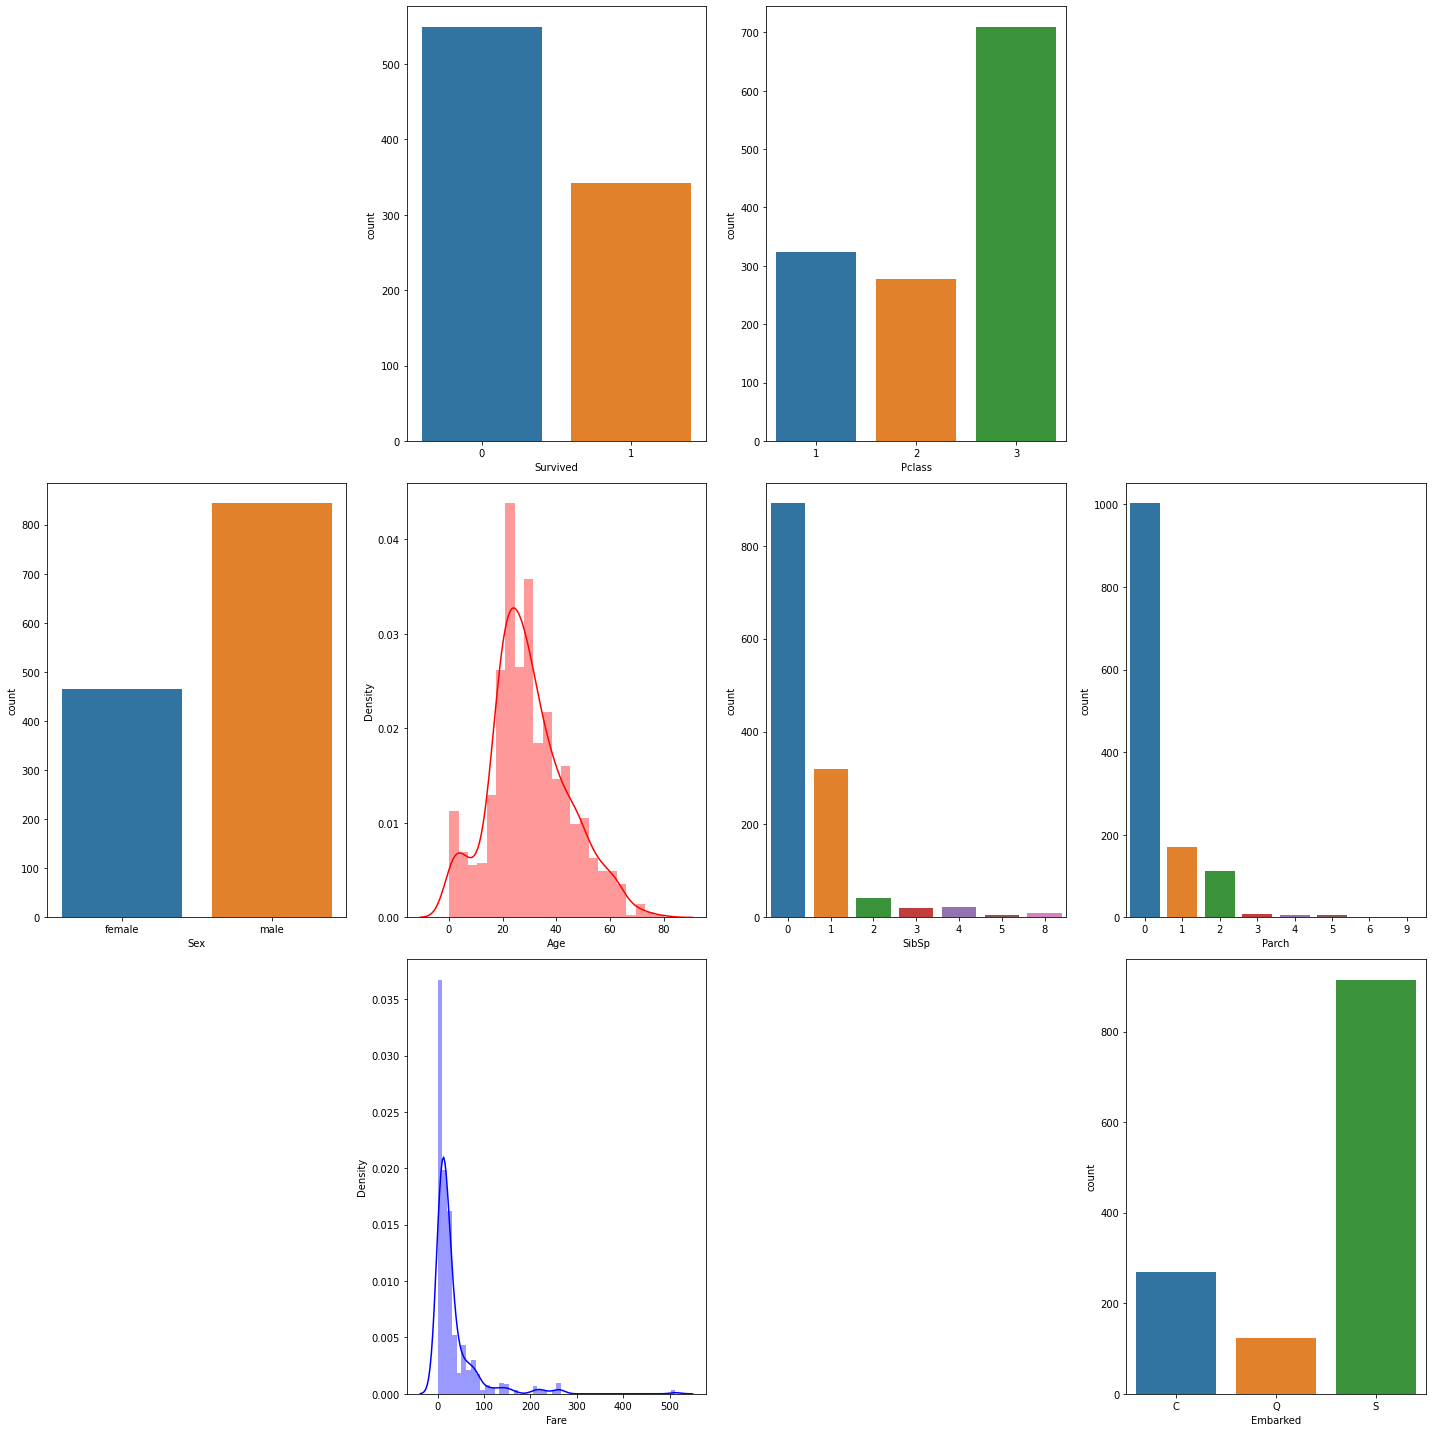

In [21]:
univariate(combined)

### EDA: Bivariate Analysis

In [22]:
def bivariate(df = combined, y = target_var, cols = 4, rows = 4):
    temp = not_plot[:]
    temp.append(y)
    fig=plt.figure(figsize=(25,20))

    for j, i in enumerate(df.columns):
        if i not in not_plot:
            if df[y].dtype == 'float':
                if i in df.select_dtypes(['category', 'object']):
                    if (i not in temp): 
                        ax=fig.add_subplot(rows,cols,j+1)
                        sns.boxplot(x = i, y = y, data = df)

                if i in df.select_dtypes(['float', 'int']):                
                    if (i not in temp):      
                        ax=fig.add_subplot(rows,cols,j+1)       
                        sns.scatterplot(x = y, y = i, data = df)                  
                
            elif df[y].dtype == 'category':
                if i in df.select_dtypes(['category', 'object']):
                    if (i not in temp):
                        ax=fig.add_subplot(rows,cols,j+1)
                        sns.countplot(x = i, hue = y, data = df)
                        plt.legend(bbox_to_anchor=(1, 1), loc=2, labels=['Not Survived', 'Survived'], borderaxespad=0.)

                if i in df.select_dtypes(['float', 'int']):
                    if (i not in temp):
                        ax=fig.add_subplot(rows,cols,j+1)
                        sns.boxplot(x = y, y = i, data = df)
    fig.tight_layout() 
    plt.show()

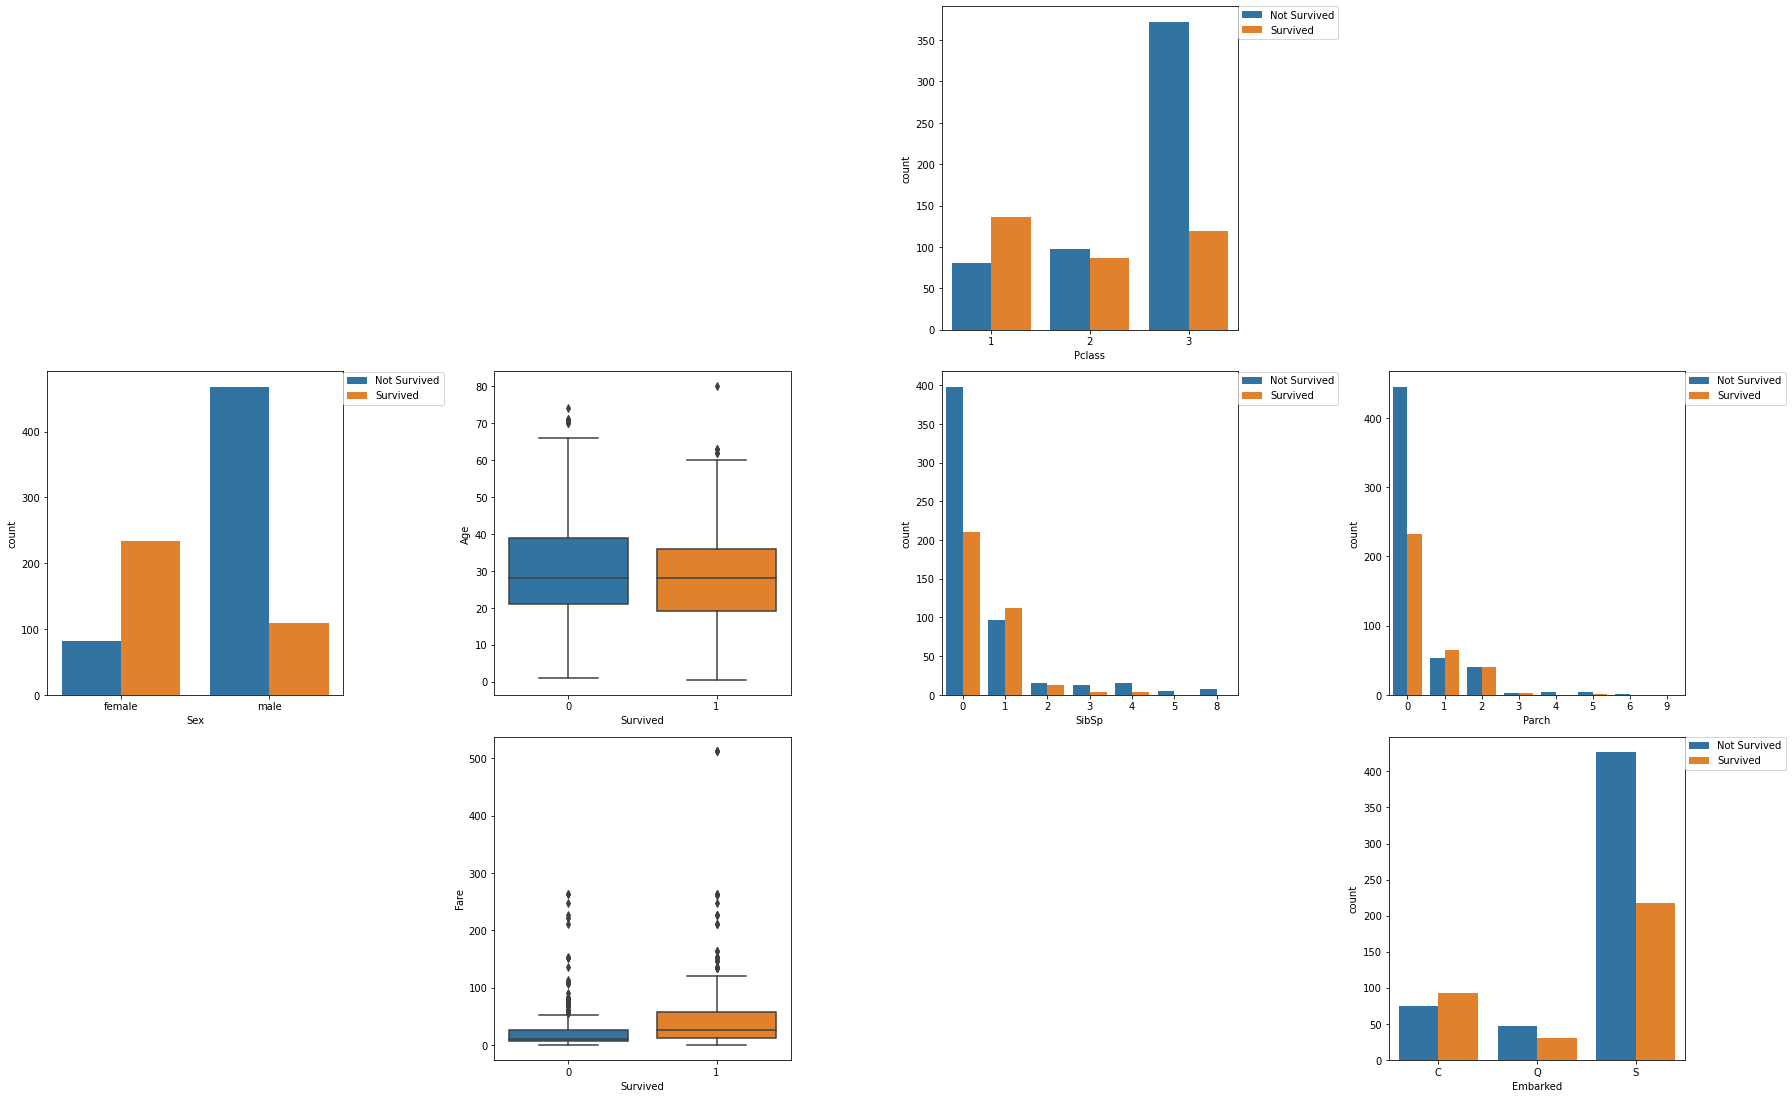

In [23]:
bivariate(combined)

### EDA: Feature Engineering

In [24]:
# To create a new column

def add_to_dataframe(x, val, df = combined):
    df[x] = val
    return df

In [25]:
temp = combined.Name.transform(lambda x:x.split('. ')[0]).transform(lambda x:x.split(', ')[1])

combined = add_to_dataframe("Titles_New", temp)

temp.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [26]:
combined.Titles_New.value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: Titles_New, dtype: int64

In [27]:
combined.Titles_New.replace(to_replace= 'Ms', value='Miss', inplace=True)

In [28]:
combined.Titles_New.replace(to_replace= ['Don', 'Rev', 'Mme', 'Mlle', 'Dona', 'Capt', 'Sir', 'the Countess', 'Jonkheer', 'Major', 'Dr', 'Col', 'Lady'], value='Others', inplace=True)

In [29]:
# Creating Family Column
to_be_num = ['SibSp', 'Parch']
combined[to_be_num] = combined[to_be_num].astype(float) 
combined['Family'] = combined.SibSp + combined.Parch + 1
combined[to_be_num] = combined[to_be_num].astype('category') 
combined.Family.head()

0    2.0
1    2.0
2    1.0
3    2.0
4    1.0
Name: Family, dtype: float64

In [30]:
combined.Family.value_counts()

1.0     790
2.0     235
3.0     159
4.0      43
6.0      25
5.0      22
7.0      16
11.0     11
8.0       8
Name: Family, dtype: int64

In [31]:
# Creating Family Category.

def total_people(x):
    if x == 1:
        return "Single"
    elif x >= 2 and x < 4:
        return "Small"
    else:
        return "Large"

combined["Family_Cat"] = combined.Family.apply(total_people)

In [32]:
combined.Family = combined.Family.astype('category')

In [33]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  1309 non-null   int64   
 1   Survived     891 non-null    category
 2   Pclass       1309 non-null   category
 3   Name         1309 non-null   category
 4   Sex          1309 non-null   category
 5   Age          1046 non-null   float64 
 6   SibSp        1309 non-null   category
 7   Parch        1309 non-null   category
 8   Ticket       1309 non-null   category
 9   Fare         1308 non-null   float64 
 10  Cabin        295 non-null    category
 11  Embarked     1307 non-null   category
 12  Titles_New   1309 non-null   object  
 13  Family       1309 non-null   category
 14  Family_Cat   1309 non-null   object  
dtypes: category(10), float64(2), int64(1), object(2)
memory usage: 157.0+ KB


In [34]:
combined.Family_Cat.value_counts()

Single    790
Small     394
Large     125
Name: Family_Cat, dtype: int64

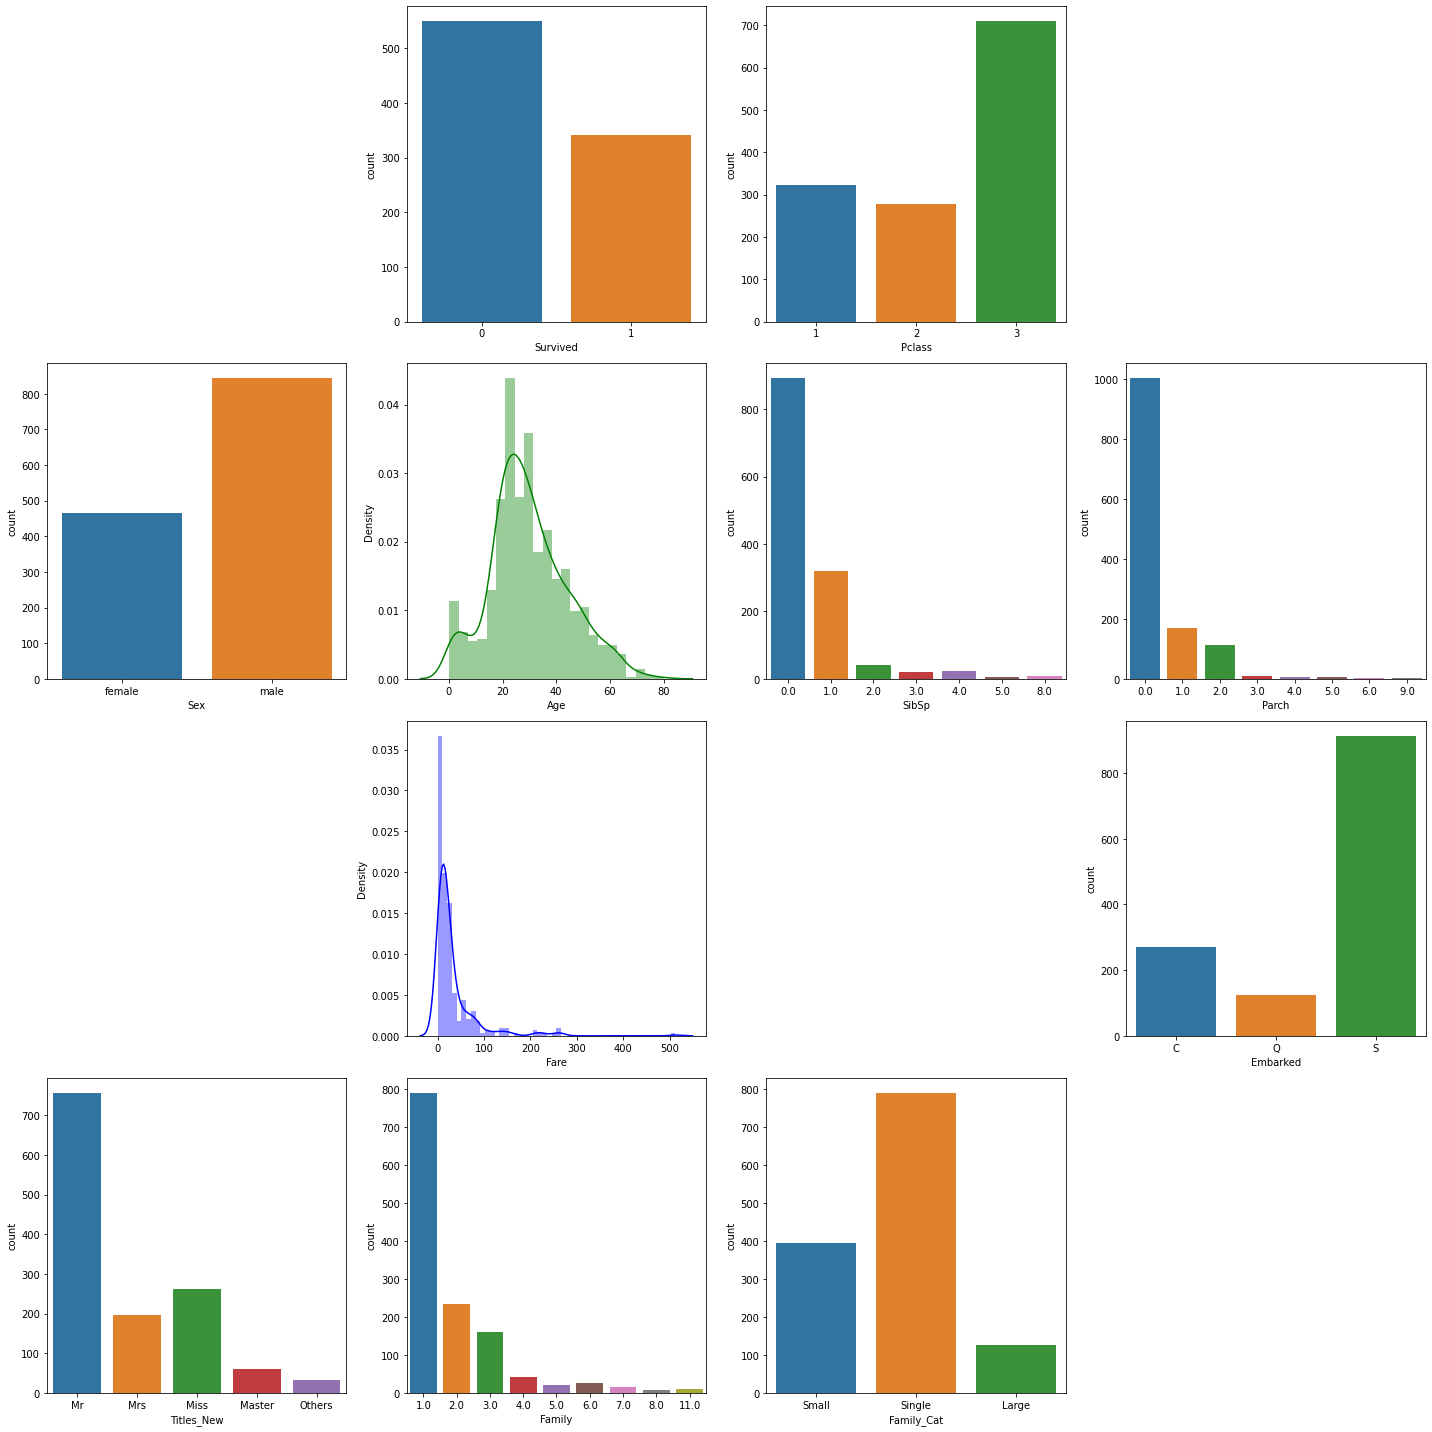

In [35]:
univariate(rows = 4)

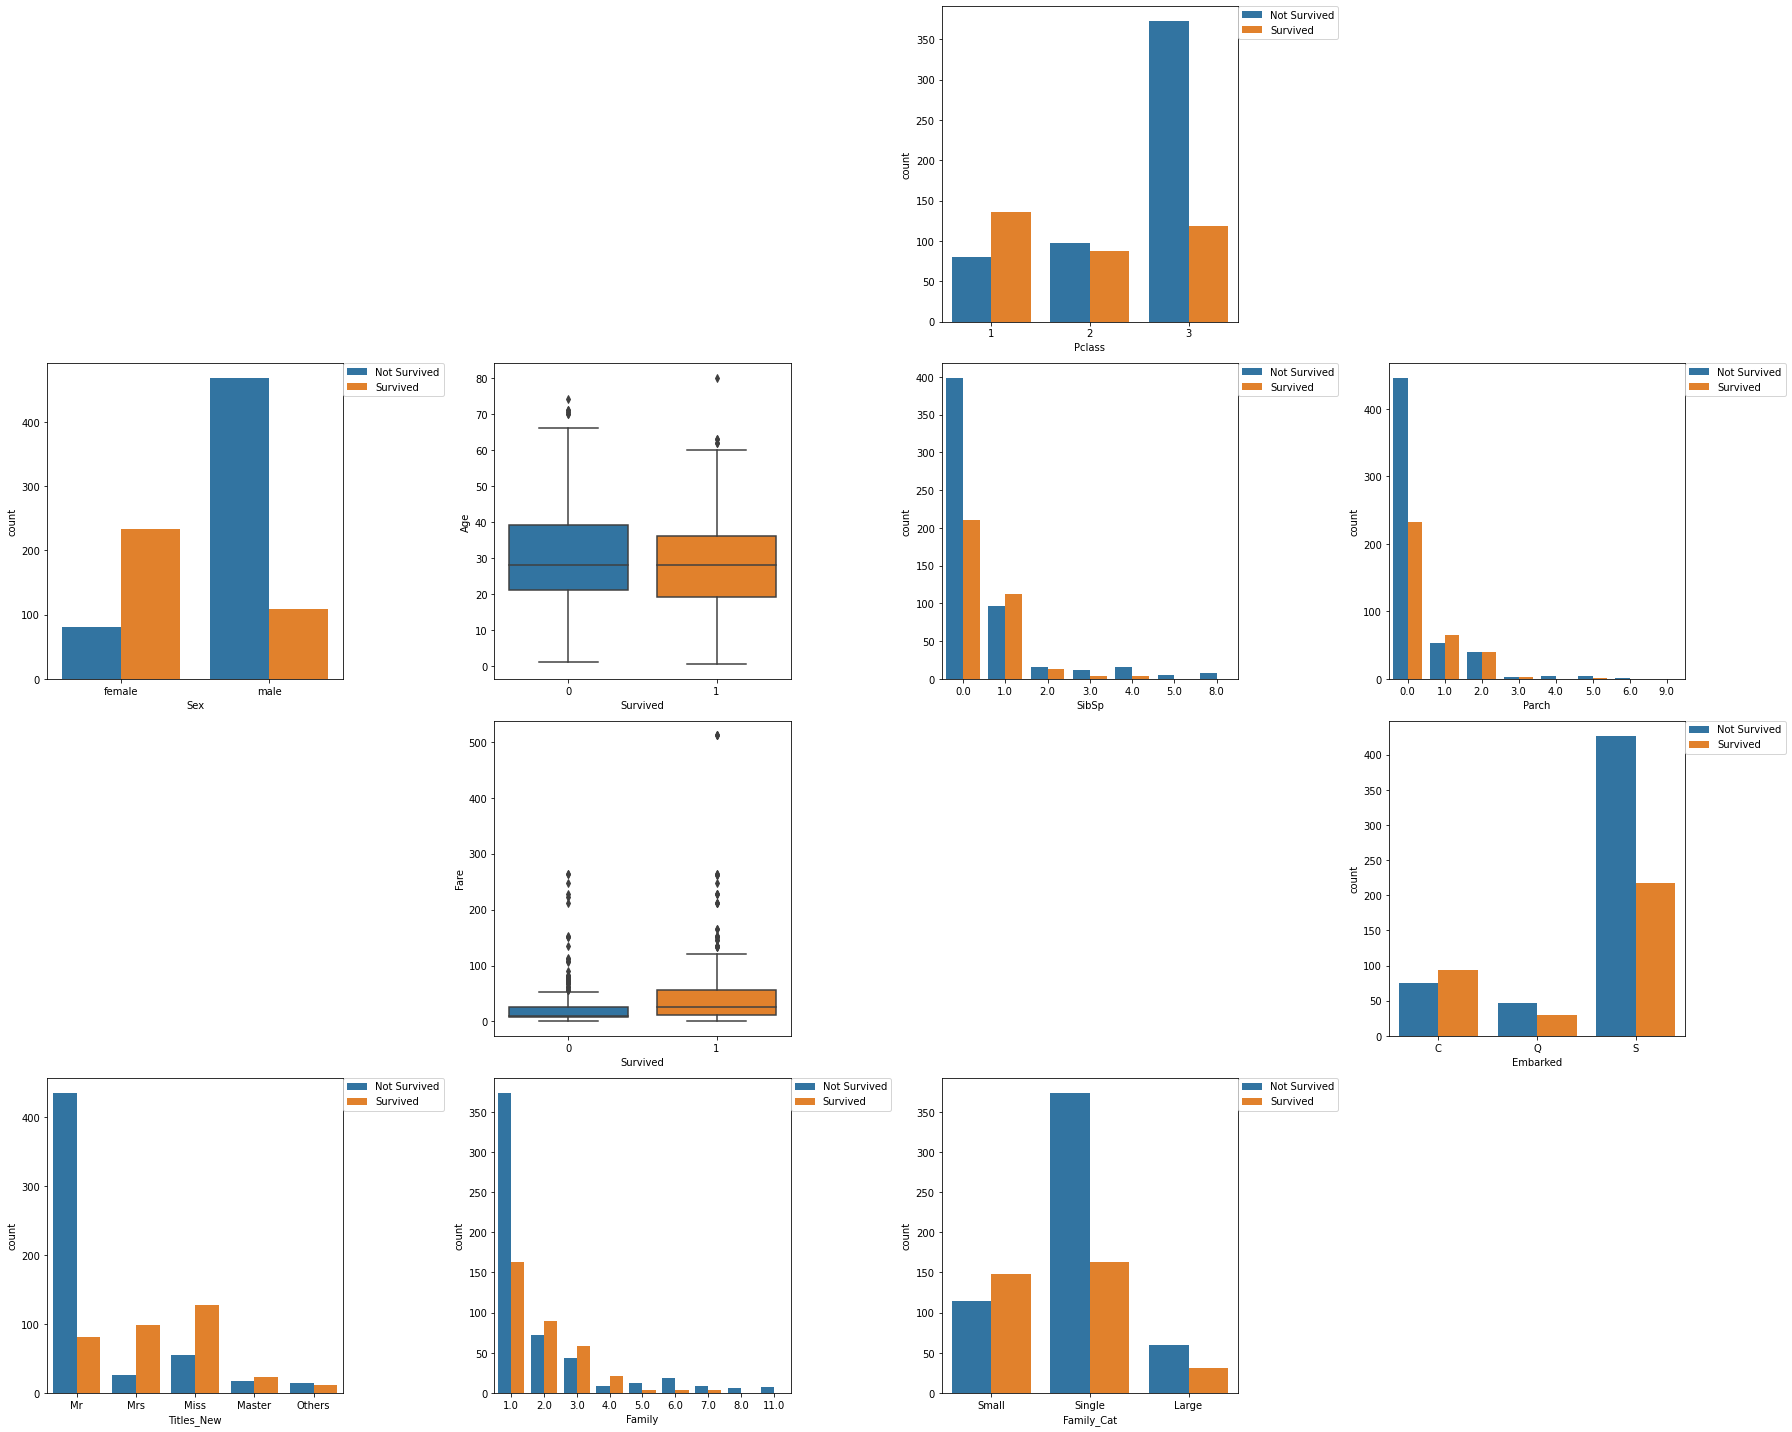

In [36]:
bivariate()

### Missing Values

In [37]:
combined.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
Titles_New        0
Family            0
Family_Cat        0
dtype: int64

In [38]:
combined.Embarked.value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

Maximum People have boarded the ship from 'Southampton', hence filling the null values as 'S'.
Just two null values would not create a big difference even if its wrong.

We could check it against Fare or TickteID or PassengerID and see if there is a relation or not. Will try later.

In [39]:
combined.Embarked.fillna('S', inplace=True)

For Missing value of Age:

1. Family_Cat has a big impact.

2. Pclass has an impact.

3. Gender has no impact.

4. Title has an impact.

In [40]:
def fill_na_Age(df):
    temp_desc = pd.DataFrame(combined.groupby(['Pclass', 'Family_Cat', 'Titles_New'])['Age'].describe())
    for i in df.Pclass.unique():
        # print(i)
        for j in df.Family_Cat.unique():
            # print(i,j)
            for k in df.Titles_New.unique():
                    # print(temp_desc.loc[i, j, k].loc['50%'])
                try:
                    if (type(temp_desc.loc[i, j, k].loc['50%']) == np.float64) & (pd.isna(temp_desc.loc[i, j, k].loc['50%']) == False):
                        # val = temp_desc.loc[i, j, k].loc['50%']
                        # tempdf = df[(df.Pclass == i) & (df.Family_Cat == j) & (df.Titles_New == k)]
                        # tempdf.Age.fillna(val, inplace=True)
                        # # tempdf.head()
                        # df[(df.Pclass == i) & (df.Family_Cat == j) & (df.Titles_New == k)] = tempdf
                        df.loc[(df.Pclass == i) & (df.Family_Cat == j) & (df.Titles_New == k) & (df.Age.isna()), 'Age'] = temp_desc.loc[i, j, k].loc['50%']
                except:
                    pass
    df.Age.fillna(combined[combined.Titles_New == 'Master']['Age'].mean(), inplace=True)

In [41]:
fill_na_Age(combined)

In [42]:
combined.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          0
Titles_New        0
Family            0
Family_Cat        0
dtype: int64

In fare, just 1 Null value would not impact much. Filling it with the total mean.

In [43]:
combined.Fare.fillna(combined.Fare.mean(), inplace=True)

In [44]:
combined.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True, axis = 1)

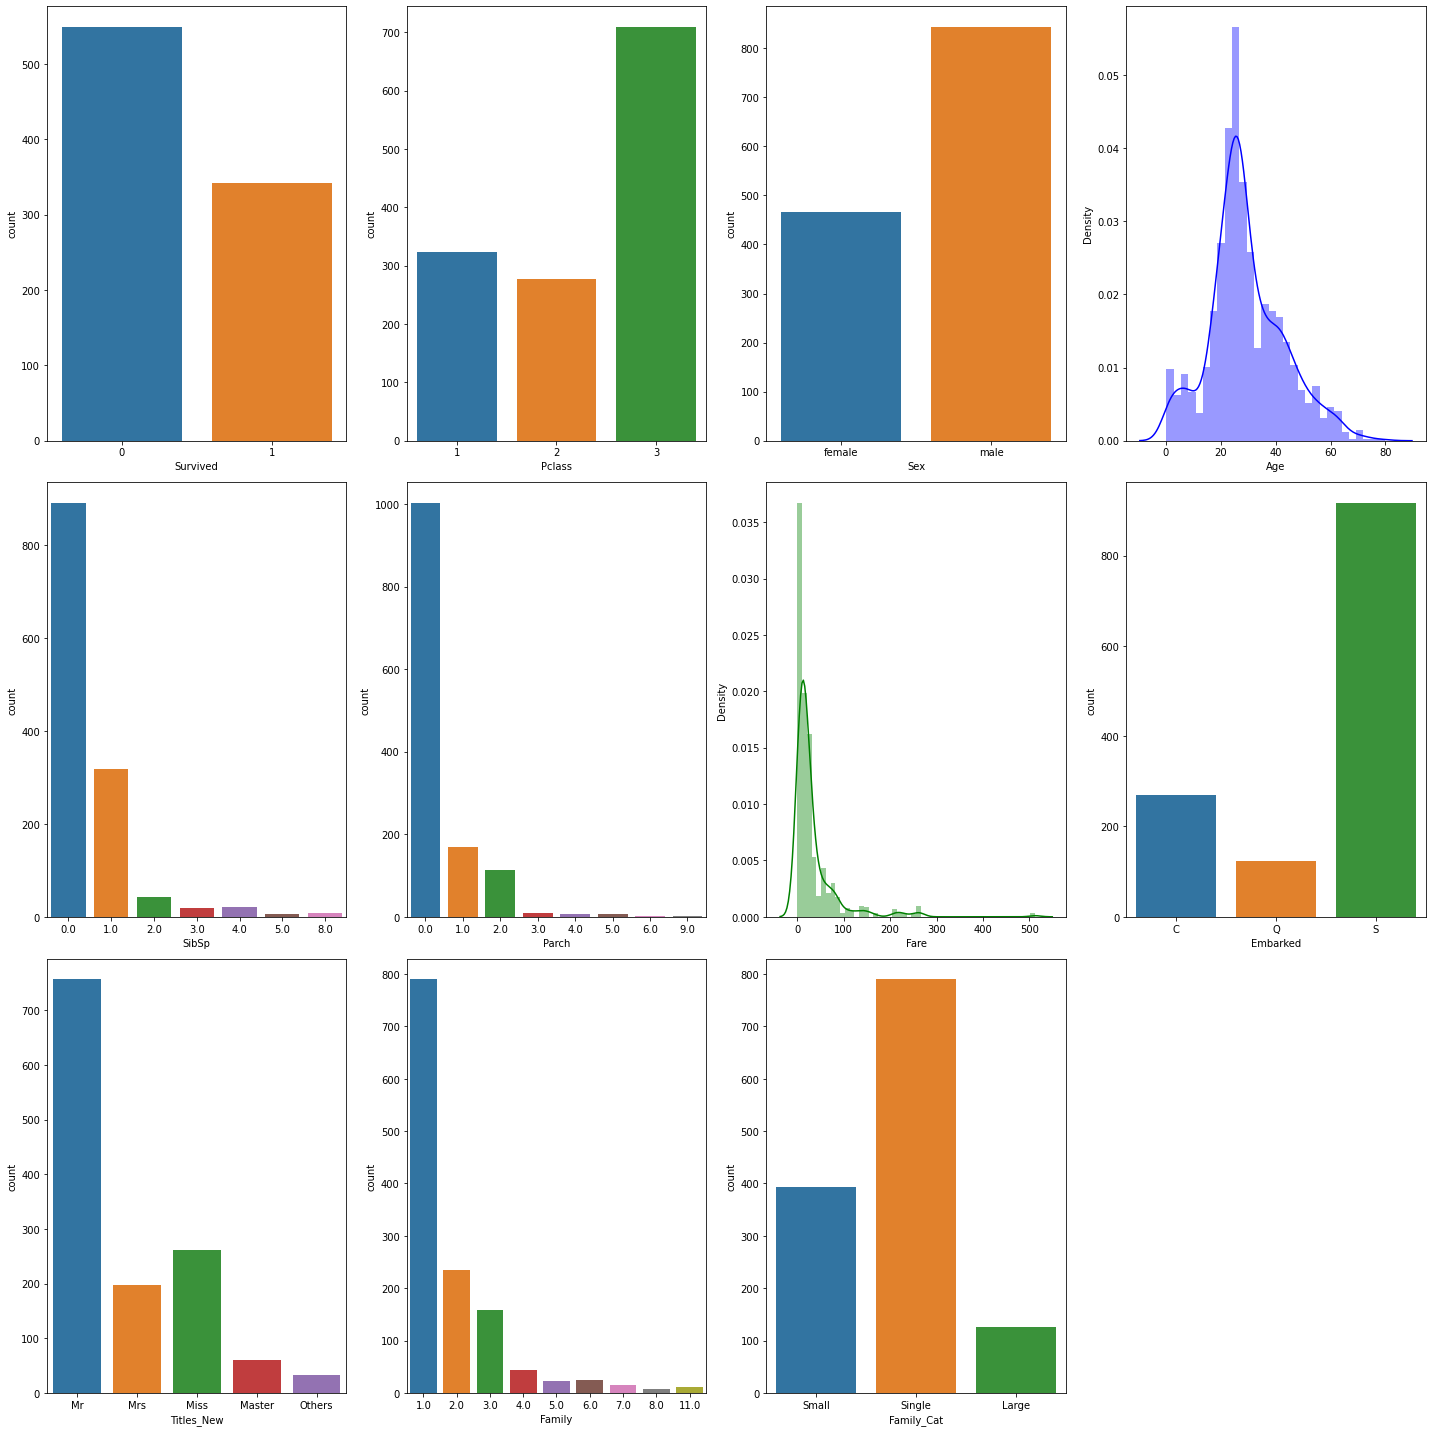

In [64]:
univariate()

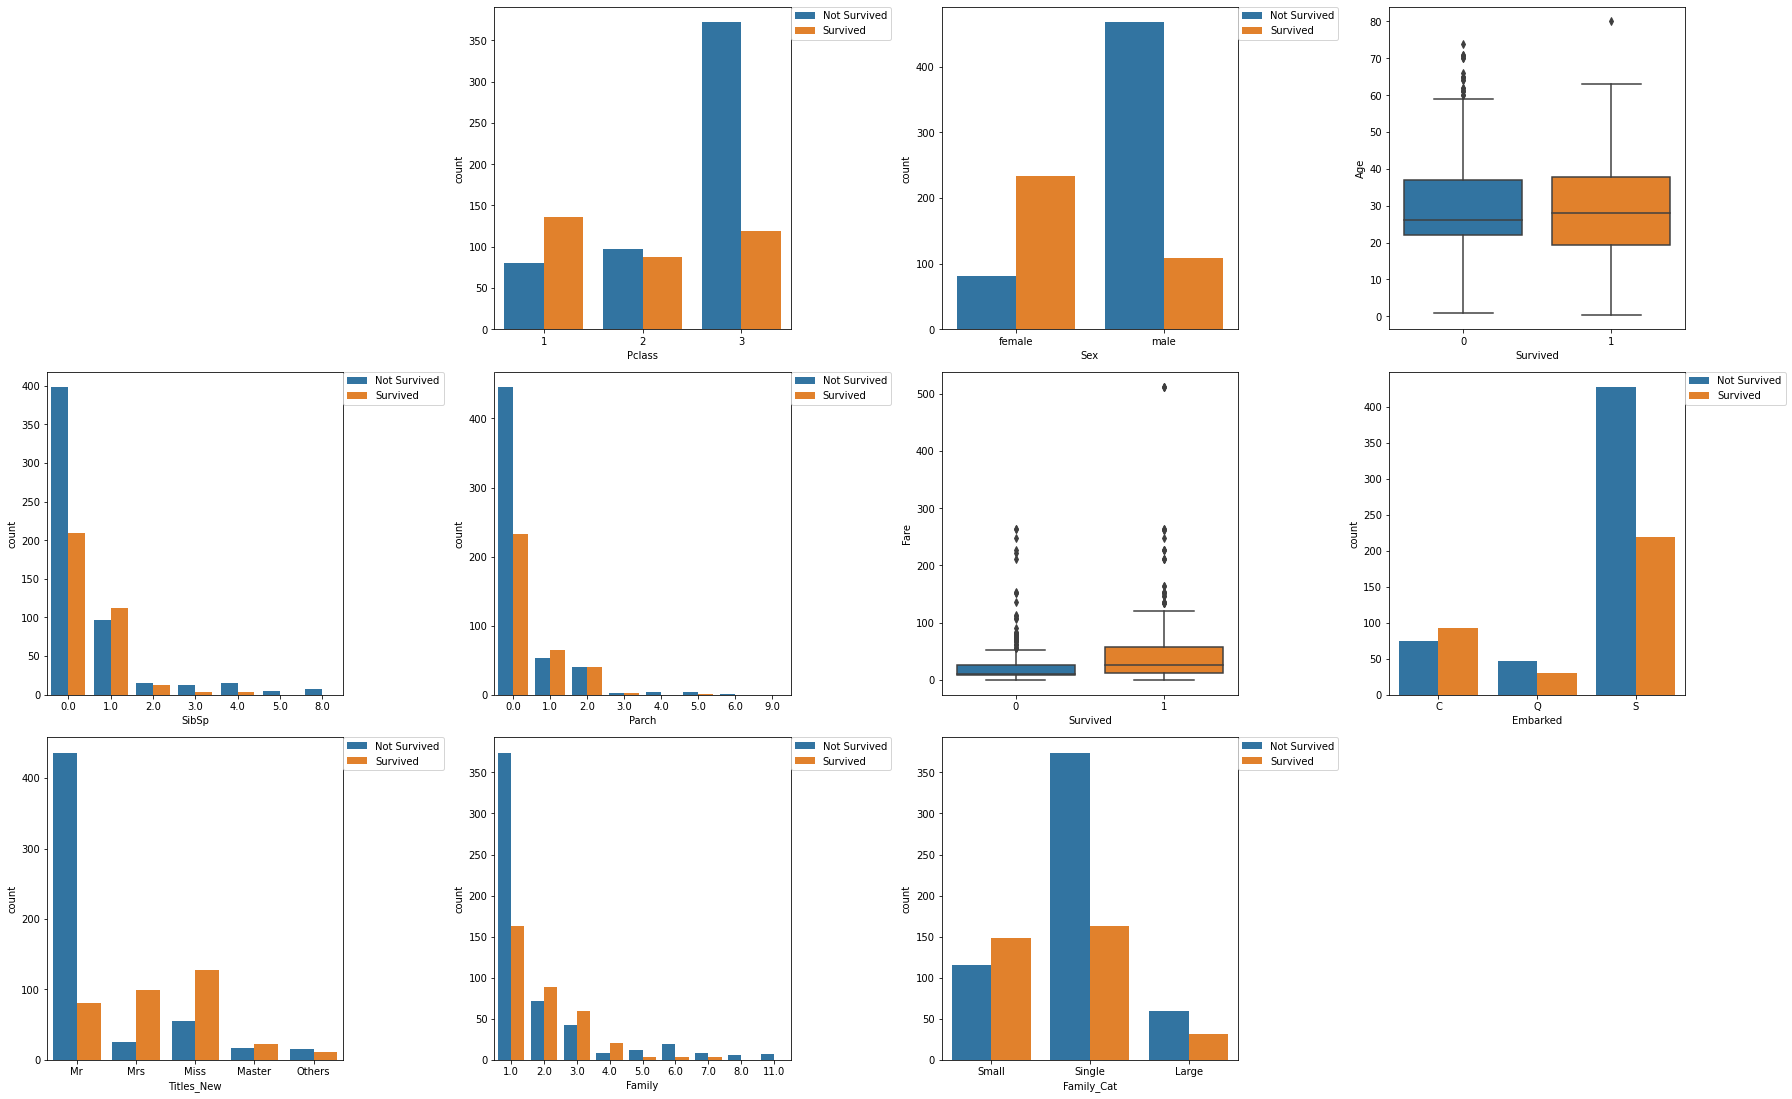

In [65]:
bivariate()

### Model Building

#### 1. Logistic Regression

In [45]:
col = combined.loc[:, combined.columns != target_var].columns

In [46]:
def logit_sum(df):
    dfc = ac(df)
    col = dfc.loc[:, dfc.columns != target_var].columns
    model = sm.Logit(df[target_var], dfc[col])
    res = model.fit()
    print(res.summary())

In [47]:
def label_enc(df = combined):
    df = df.dropna()
    # print(df.head())
    return df.apply(LabelEncoder().fit_transform)

In [48]:
combined_lb = label_enc()
combined_lb.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Titles_New,Family,Family_Cat
0,0,2,1,29,1,0,18,2,2,1,2
1,1,0,0,53,1,0,207,0,3,1,2
2,1,2,0,35,0,0,41,2,1,0,1
3,1,0,0,49,1,0,189,2,3,1,2
4,0,2,1,49,0,0,43,2,2,0,1


In [49]:
logit_sum(combined_lb)

Optimization terminated successfully.
         Current function value: 0.433021
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      881
Method:                           MLE   Df Model:                            9
Date:                Mon, 18 Jul 2022   Pseudo R-squ.:                  0.3497
Time:                        16:08:07   Log-Likelihood:                -385.82
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 8.563e-84
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3563      0.645      5.205      0.000       2.092       4.620
Pclass        -0.9460      0.

In [50]:
# Removing cols with p-value more than 0.05

def back_feat_elem(df, y = combined_lb[target_var]):
    # df = label_enc(df)
    dfc = ac(df)
    colm = dfc.loc[:, dfc.columns != target_var].columns
    # print(col)
    while len(colm) > 0:
        model = sm.Logit(y, dfc[colm])
        result = model.fit(disp= 0)
        largest_pvalue = round(result.pvalues, 3).nlargest(1)
        if largest_pvalue[0] < (0.05):
            return result
            break
        else:
            colm= colm.drop(largest_pvalue.index)

In [51]:
back_res = back_feat_elem(combined_lb)
back_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      885
Method:                           MLE   Df Model:                            5
Date:                Mon, 18 Jul 2022   Pseudo R-squ.:                  0.3406
Time:                        16:08:08   Log-Likelihood:                -391.24
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 3.723e-85
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6716      0.473      7.765      0.000       2.745       4.598
Pclass        -1.2365      0.130     -9.475      0.000      -1.492      -0.981
Sex           -2.7189      0.199    -13.661      0.000      -3.109      -2.329
Age           -0.0318      0.006     -5.255      0.000      -0.044      -0.020
Family        -0.1984      0.069     -2.864      0.004      -0.334      -0.063
Family_Cat     0.4175      0.151      2.757      0.006       0.121       0.714
==============================================================================
"""

In [52]:
ind = list(back_res.params.index)
ind.remove('const')
ind

['Pclass', 'Sex', 'Age', 'Family', 'Family_Cat']

In [53]:
# Storing the above columns in another DataFrame

new_x = combined[ind]
new_y = combined.Survived
new_df = pd.concat([new_x, new_y], axis=1)
new_df.head()

,Pclass,Sex,Age,Family,Family_Cat,Survived
0,3,male,22.0,2.0,Small,0
1,1,female,38.0,2.0,Small,1
2,3,female,26.0,1.0,Single,1
3,1,female,35.0,2.0,Small,1
4,3,male,35.0,1.0,Single,0


In [54]:
new_df.isnull().sum()

Pclass          0
Sex             0
Age             0
Family          0
Family_Cat      0
Survived      418
dtype: int64

Now We have best columns, lets apply modelling.

In [55]:
params_lg = {
    'penalty': ['l1', 'l2','elasticnet'],
    'tol': [0.1, 0.01],
    'C': [0.1, 0.01],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [10, 100],
    'multi_class': ['auto', 'ovr','multinomial'],
    'n_jobs': [3,4],
}

In [56]:
# grid_search(LogisticRegression(), params_lg, new_df, 'd', 'yes')

# Kaggle Score = 0.75837

#### 2. Decision Tree

In [57]:
params_dt = {
    'criterion': ['gini','entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [3, 6, 9],
    'min_samples_leaf': [5, 8, 11],
    'max_features': ['sqrt', 'log2'],
}

In [58]:
# grid_search(DecisionTreeClassifier(), params_dt, new_df, 'd', 'yes')

# Kaggle Score = 0.71770

#### 3. Random Forest Classifier

In [59]:
rf_params = {
    'n_estimators': [10, 50, 100, 150, 200],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [10, 15, 20, 25, 40],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'oob_score': [True],
    'n_jobs': [-1],
}

In [60]:
# grid_search(RandomForestClassifier(), rf_params, new_df, 'd', 'yes')

# Kaggle Score = 0.72488

#### 4. KNN Classification

In [61]:
params_knn = {
    'n_neighbors': [1, 3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'n_jobs': [-1],
    'p':[0,1,2,i]
}

In [63]:
# grid_search(KNeighborsClassifier(), params_knn, new_df, 'd', 'yes')

# Kaggle Score = 0.73684

<IPython.core.display.Javascript object>

### **Outlier**

1. Boxplot: Visualisation
2. 1.5 * IQR [IQR is (Q3 - Q1)] Identifying Outliers

In Case of Normal Distribution, anything beyond 3 Sigma is considered to be an outlier. However this is rare as most values are already covered.

When in any dataset we want to find out the association b/w:

1. Categorical and Numerical -> ANOVA - Analysis of Variance(ftest).

    1.1. Most Imp feature in ANOVA is it can be easily performed on multi categorical data set.

2. Categorical and Categorical -> Chi Square.

3. Numerical and Numerical -> ttest.

In [56]:
import scipy.stats as stats
from statsmodels.formula.api import ols

Hypothesis is that PClass has some effect on Age.

H0: PClass has **NO** effect on Age. (or Mean of Passengers of Pclass 1 = Mean of Passengers of Pclass 2 = Mean of Passengers of Pclass 3)

H1: PClass has has some effect on Age.

In [57]:
# stats.f_oneway(dg1, dg2, ... , dgN)

stats.f_oneway(
    combined.loc[combined["Pclass"] == '1']['Age'].dropna(),
    combined.loc[combined['Pclass'] == '2']['Age'].dropna(), 
    combined.loc[combined['Pclass'] == '3']['Age'].dropna())

F_onewayResult(statistic=108.32631005902482, pvalue=1.796708368328782e-43)

**ANOVA Interpretation**

P-Value is less than 0.05, we fail to accept the **H0**. PClass holds a significant impact on the Age.

We can use PClass while imputting Missing Values

In [58]:
combined.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Titles_New', 'Family', 'Family_Cat', 'Cabin_Avail'],
      dtype='object')

In [59]:
combined.Family_Cat.value_counts()

Single    790
Small     394
Large     125
Name: Family_Cat, dtype: int64

In [60]:
# In case of multiple feature check

model = ols('Age ~ Embarked', combined ).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     3.917
Date:                Tue, 21 Jun 2022   Prob (F-statistic):             0.0202
Time:                        16:13:30   Log-Likelihood:                -4270.7
No. Observations:                1046   AIC:                             8547.
Df Residuals:                    1043   BIC:                             8562.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        32.3322      0.987     32.752      0.000      30.395      34.269
Embarked[T.Q]    -3.7022      2.260     -1.638      0.102      -8.136       0.732
Embarked[T.S]    -3.0340      1.113     -2.727      0.007      -5.217      -0.851
==============================================================================
Omnibus:                       27.123   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.547
Skew:                           0.395   Prob(JB):                     6.33e-07
Kurtosis:                       3.174   Cond. No.                         6.83
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
stats.f_oneway(
    combined.loc[combined["Family_Cat"] == 'Small']['Age'].dropna(),
    combined.loc[combined['Family_Cat'] == 'Single']['Age'].dropna(),
    combined.loc[combined['Family_Cat'] == 'Large']['Age'].dropna())

F_onewayResult(statistic=31.39714125133197, pvalue=5.74246670225981e-14)